# Notes on the assignment
Test whether the data is consistent with the theory of beta convergence. Treat $\mathbf{z}_i$ as high-dim.
$$
g_i = \beta y_{i0} + \mathbf{z}_i'\gamma + u_i
$$
$y_{i0}$ is the initial log GDP per capita. The controls are $\mathbf{z}_i$ and $u_i$ is an idiosyncratic error term.
### Tasks
Core tasks:
1. Select regressors, see Overleaf for prioritized list.
2. Insert functions from exercise classes into functions_lasso.py.
3. Estimate model.
4. Construct confidence intervals.
5. Plot results.
6. Tabularize results.

### Workflow
1. Selection of regressors using BRT. Then implement BCCH afterwards, then CV.
    1. Remember standardization of variables (lecture 6 slide 22).
    2. Remember $c$ and $\alpha$ values, taken from BCCH paper. (adjusts rate of converge)
2. Estimate LS
3. Estimate LASSO
4. Estimate post-LASSO
5. Estimate post-double LASSO
6. Estimate post-partialling out LASSO (should be asymptotically equivalent to post-double LASSO selection)


### If time permits
1. Interpolation of missing data (or imputation).
    1. See bonus material under Project 2 on Absalon.

In [82]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from scipy.stats import norm
import seaborn as sns
# from sklearn.preprocessing import PolynomialFeatures
from functions_lasso import *

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
# Read data
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # dictionary of labels: description.

In [84]:
# Variables in dataset, by category.
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

In [85]:
# print(dat.info())

In [86]:
# List of all variables
l_all_v = []
for category, varlist in vv_all.items():
    l_all_v += varlist


l_all_v.append("gdp_growth")
l_all_v.append("lgdp_initial")


# 1. Amount of complete observations for all variables = 63:
I = dat[l_all_v].notnull().all(axis=1)
country_index_in_complete_dataset = np.extract(I, dat.index)
# The list of selected variables are of course all variables with atleast non-empty columns.

# Amount of observations with complete data for gdp_growth and lgdp_initial = 109:
# 1. I = True and false index for complete cases of gdp_growth and lgdp_initial
I = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)

# 2. The variables that have complete data for these observations
I_each = {}
for v in l_all_v:
    I_v = dat.loc[I, v].notnull()
    I_each[v] = I_v
# 3. The list of selected variables with complete data for these observations;
# ['area', 'cenlong', 'africa', 'asia', 'oceania', 'americas', 'pdiv',
#  'pprotest', 'pcatholic', 'pmuslim', 'uvdamage', 'gdp_growth', 'lgdp_initial']
selected_vars = []
for key in I_each.keys():
    if I_each[key].all():
        selected_vars.append(key)


In [87]:
# Data cleaning and adding controls
zs_common_control = ['pop_growth', 'investment_rate']
zs_uncommon_control = vv_all['geography'] + vv_all['resources'] + vv_all['danger'] + ['dem'] + ['demCGV'] + ['demBMR'] + vv_all['religion']  
zs = zs_common_control + zs_uncommon_control

ds = ['lgdp_initial']
ys = ['gdp_growth']
xs = ds + zs
all_vars = ['gdp_growth'] + xs
dummy_vars = ['dem', 'demCGV', 'demBMR']
dat[dummy_vars] = dat[dummy_vars].fillna(0)

# Filter missing data
I = dat[all_vars].notnull().all(axis=1)
Z = dat.loc[I, zs].to_numpy()
print(Z.shape)


##### START - Mathias suggestion for handling binary variables:
binary_mask = np.all(np.isin(Z, [0, 1]), axis=0)
Z_nonbinary = Z[:, ~binary_mask]
Z_binary = Z[:, binary_mask] 

zs_arr = np.array(zs)
zs_nonbinary = zs_arr[~binary_mask].tolist()
zs_binary = zs_arr[binary_mask].tolist()

# print(f'Number of non-binary variables: {Z_nonbinary.shape[1]}')
# print(f'Number of binary variables: {binary_mask.sum()}')
poly = PolynomialFeatures(degree = 2, include_bias=False)
Z_pol = poly.fit_transform(Z_nonbinary)
# print(f'After polynomial expansion, number of variables: {Z_pol.shape[1]}')
binary_mask_pol = np.all(np.isin(Z_pol, [0, 1]), axis=0) # check 
Z_final = np.hstack([Z_pol, Z_binary])
# print(f'Total number of variables after adding binary vars: {Z_final.shape[1]}')
names_pol = poly.get_feature_names_out(input_features=zs_nonbinary)
names_zs = np.hstack([names_pol, zs_binary])
# print(f'Final variable names: {names_final}, shape: {names_final.shape}')
names_xs = np.hstack(['lgdp_initial', names_zs])
# ##### END



# names_xs = xs
# names_zs = zs




# Some constants
rounding_digits = 12


# Note is the full matrix collection of variables of D and Z.
D = dat.loc[I, ds].to_numpy().reshape((-1,))
# X = dat.loc[I, xs].to_numpy() 
X = np.column_stack((dat.loc[I, ['lgdp_initial']].to_numpy(), Z_final))
y = dat.loc[I, ys].values.reshape((-1,)) * 100

# Standardize all variables (so no need for constant terms)
# Z_std = standardize(Z)
Z_std = standardize(Z_final)
D_std = standardize(D)
X_std = standardize(X)
# y_std = standardize(y)

print(X_std.shape)
print(Z_std.shape)
print(D_std.shape)
print(y.shape)
# Check full rank
K = X_std.shape[1]
# assert np.linalg.matrix_rank(X_std) == X_std.shape[1], f'X does not have full rank'

(88, 37)
(88, 444)
(88, 443)
(88,)
(88,)


In [88]:
# # Plot for selected countries.
# country_code = dat.loc[I, 'code'] # country code for I criterion.
# # print(country_code.shape[0] == X.shape[0]) # dimension check

# # data_selected = pd.DataFrame(X, columns=xs, index=country_code)

# y_df = pd.DataFrame(y, columns=['gdp_growth'], index=country_code)
# # data_final = pd.concat([y_df, data_selected], axis=1)

# # ax_data = data_final.plot.scatter(x='lgdp_initial', y='gdp_growth')
# for idx, row in data_final.iterrows():
#     ax_data.annotate(idx, (row['lgdp_initial'], row['gdp_growth']))

#### Model estimates, for OLS, PSL, PDL, PPL.
Penalties CV, BRT and BCCH are applied for LASSO based methods.

In [89]:
# OLS estimation
# OLS without controls
X_no_control = D_std
X_no_control = np.column_stack((X_no_control, np.ones(X_no_control.shape[0])))  # add constant
beta_hat_no_controls = np.linalg.inv(X_no_control.T @ X_no_control) @ X_no_control.T @ y
res_OLS_no_controls = y - X_no_control @ beta_hat_no_controls
print("lgdp_initial estimate, OLS without controls:", beta_hat_no_controls[0].round(rounding_digits))

# OLS with all controls
# X_with_control = X_std
X_with_control = standardize(dat.loc[I, xs].to_numpy())
X_with_control = np.column_stack((X_with_control, np.ones(X_with_control.shape[0])))  # add constant
beta_hat_w_controls = np.linalg.inv(X_with_control.T @ X_with_control) @ X_with_control.T @ y
res_OLS_w_controls = y - X_with_control @ beta_hat_w_controls
print("lgdp_initial estimate, OLS with all controls:", beta_hat_w_controls[0].round(rounding_digits))

lgdp_initial estimate, OLS without controls: -0.166172775192
lgdp_initial estimate, OLS with all controls: -1.926694888468


##### CV, BRT and BCCH penalties

In [90]:
# # Function for string output for selected variables.
# def np.array(selected_variables, label_list=xs):
#     xs_selected = []
#     for i in range(0,len(selected_variables)):
#         if selected_variables[i] == True:
#             xs_selected.append(i)
#     xs_varname = []

#     for var_index in range(len(xs_selected)):
#         xs_varname.append(label_list[var_index])

#     return xs_varname

In [91]:
# Penalty grid for Lasso.
penalty_grid = np.geomspace(start=0.001, stop=100, num=100)
max_iterations = 100000

In [92]:
# penalty_BRT = BRT(X_tilde=X_std, y=y_std)
# fit_BRT = Lasso(alpha=penalty_BRT,  max_iter=max_iterations).fit(X_std, y_std.reshape(-1,))
# coefs_BRT = fit_BRT.coef_

# selected_variables_BRT = (coefs_BRT != 0)

# print("Selected variables with Lasso BRT penalty:", np.array(names_xs)[selected_variables_BRT])# 

In [ ]:
# Lasso with CV, five folds:
fit_CV = LassoCV(alphas=penalty_grid,  cv=5, max_iter=max_iterations).fit(X_std, y.reshape(-1,))
penalty_CV = fit_CV.alpha_
coefs_CV = fit_CV.coef_
selected_variables_CV = (coefs_CV != 0)
print("Selected variables with Lasso CV penalty:", np.array(names_xs)[selected_variables_CV])

# Lasso with BRT penalty:
penalty_BRT = BRT(X_tilde=X_std, y=y)
fit_BRT = Lasso(alpha=penalty_BRT,  max_iter=max_iterations).fit(X_std, y.reshape(-1,))
coefs_BRT = fit_BRT.coef_
selected_variables_BRT = (coefs_BRT != 0)
print("Selected variables with Lasso BRT penalty:", np.array(names_xs)[selected_variables_BRT])

# Lasso with BCCH penalty:
penalty_BCCH = BCCH(X_tilde=X_std, y=y)
fit_BCCH = Lasso(alpha=penalty_BCCH,  max_iter=max_iterations).fit(X_std, y.reshape(-1,))
coefs_BCCH = fit_BCCH.coef_
selected_variables_BCCH = (coefs_BCCH != 0)
print("Selected variables with Lasso BCCH penalty:", np.array(names_xs)[selected_variables_BCCH])


Selected variables with Lasso CV penalty: ['lgdp_initial' 'investment_rate' 'pop_growth^2' 'pop_growth temp'
 'pop_growth malfal' 'investment_rate cenlong' 'investment_rate pmuslim'
 'tropicar oilres' 'distr^2' 'distr temp' 'distr goldm' 'distr pcatholic'
 'distc area' 'elevavg area_ar' 'elevavg rough' 'elevstd area'
 'kgatr malfal' 'precip malfal' 'abslat malfal' 'abslat pcatholic'
 'cenlong^2' 'iron pprotest' 'zinc pmuslim' 'malfal pprotest'
 'pprotest pcatholic' 'demBMR']
Selected variables with Lasso BRT penalty: ['malfal^2' 'asia']
Selected variables with Lasso BCCH penalty: []


##### LASSO path

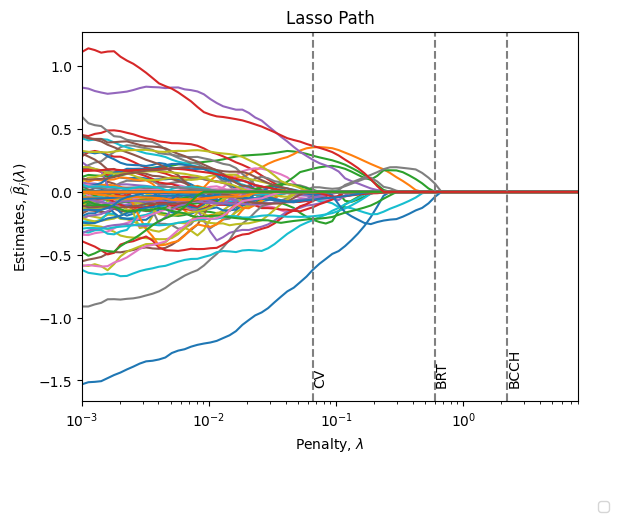

In [ ]:
# Coefficients for Lasso path
coefs = []
for penal in penalty_grid:
    fit = Lasso(alpha=penal, max_iter=max_iterations).fit(X_std, y)
    coefs.append(fit.coef_)

# Plot Lasso path
plot_lasso_path(penalty_grid=penalty_grid, coefs=coefs, vlines={'BCCH':penalty_BCCH,'BRT':penalty_BRT, 'CV':penalty_CV}) # legends=names_final

#### OLS for Post LASSO methods

##### Post single LASSO:

In [114]:
# PSL
# CV
def PSL_function(X, D, y, penalty_type):
    
    N = X.shape[0]

    if penalty_type == 'CV':
    
        # Step 1 Lasso Y on Z and D
        PSL_fit_Y_on_Z_D_CV = LassoCV(alphas=penalty_grid, cv=5, max_iter=max_iterations).fit(X_std, y)
        PSL_coefs_CV = PSL_fit_Y_on_Z_D_CV.coef_
        PSL_selected_variables_CV = (PSL_coefs_CV != 0)

        Z_J = X[:, PSL_selected_variables_CV]  # exclude lgdp_initial
        # Add a constant to X
        xx = np.column_stack((np.ones(N),D,Z_J))
        yy = np.array(y).reshape(-1,1)

        # Calculate OLS estimate
        coefs_PSL = np.linalg.inv(xx.T@xx)@xx.T@yy
        alpha_PSL = coefs_PSL[1][0]
        # Calculate residuals
        res_PSL = yy - xx@coefs_PSL

    elif penalty_type == 'BRT':
        # Step 1 Lasso Y on Z and D
        PSL_fit_Y_on_Z_D_BRT = Lasso(alpha=penalty_BRT, max_iter=max_iterations).fit(X_std, y)
        PSL_coefs_BRT = PSL_fit_Y_on_Z_D_BRT.coef_
        PSL_selected_variables_BRT = (PSL_coefs_BRT != 0)

        Z_J = X[:, PSL_selected_variables_BRT]  # exclude lgdp_initial
        # Add a constant to X
        xx = np.column_stack((np.ones(N),D,Z_J))
        yy = np.array(y).reshape(-1,1)

        # Calculate OLS estimate
        coefs_PSL = np.linalg.inv(xx.T@xx)@xx.T@yy
        alpha_PSL = coefs_PSL[1][0]
        # Calculate residuals
        res_PSL = yy - xx@coefs_PSL

    elif penalty_type == 'BCCH':
        # Step 1 Lasso Y on Z and D
        PSL_fit_Y_on_Z_D_BCCH = Lasso(alpha=penalty_BCCH, max_iter=max_iterations).fit(X_std, y)
        PSL_coefs_BCCH = PSL_fit_Y_on_Z_D_BCCH.coef_
        PSL_selected_variables_BCCH = (PSL_coefs_BCCH != 0)

        Z_J = X[:, PSL_selected_variables_BCCH]  # exclude lgdp_initial
        # Add a constant to X
        xx = np.column_stack((np.ones(N),D,Z_J))
        yy = np.array(y).reshape(-1,1)

        # Calculate OLS estimate
        coefs_PSL = np.linalg.inv(xx.T@xx)@xx.T@yy
        alpha_PSL = coefs_PSL[1][0]
        # Calculate residuals
        res_PSL = yy - xx@coefs_PSL
    
    return alpha_PSL, res_PSL
# Display alpha
# Step 1 Lasso Y on Z and D

alpha_PSL_CV, res_PSL_CV = PSL_function(X, D, y, penalty_type='CV')
alpha_PSL_BRT, res_PSL_BRT = PSL_function(X, D, y, penalty_type='BRT')
alpha_PSL_BCCH, res_PSL_BCCH = PSL_function(X, D, y, penalty_type='BCCH')

print("PSL estimate with CV penalty:", alpha_PSL_CV.round(rounding_digits))
print("PSL estimate with BRT penalty:", alpha_PSL_BRT.round(rounding_digits))
print("PSL estimate with BCCH penalty:", alpha_PSL_BCCH.round(rounding_digits))


PSL estimate with CV penalty: 1.0607302328604918e+17
PSL estimate with BRT penalty: -0.359959379194
PSL estimate with BCCH penalty: -0.120927076306


##### Post Double Lasso:

In [52]:
fit = LassoCV(alphas=penalty_grid, cv=5, max_iter=max_iterations).fit(Z_std, D.reshape(-1,))
coefs_Z_D = fit.coef_
prediction = fit.predict(Z_std)


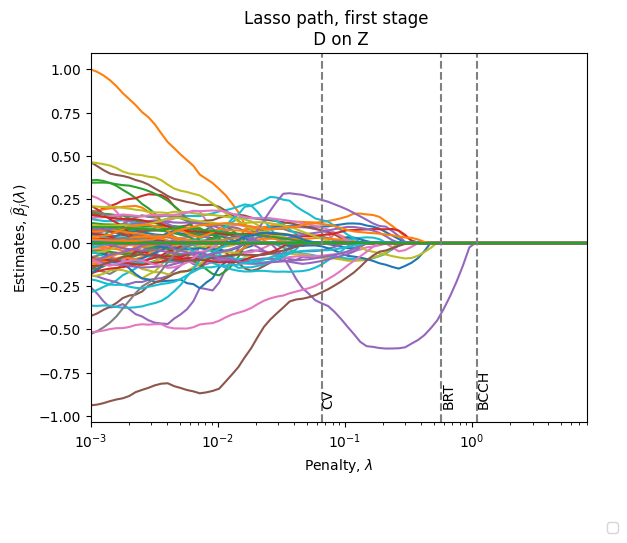

Selected vars 1. stage, CV penalty: ['uvdamage' 'pop_growth suitavg' 'pop_growth abslat' 'investment_rate^2'
 'investment_rate pprotest' 'investment_rate pcatholic' 'distr goldm'
 'distr silv' 'distc suitavg' 'distc precip' 'distc cenlong'
 'suitavg abslat' 'elevavg^2' 'elevavg precip' 'elevavg cenlong'
 'elevstd area_ar' 'elevstd malfal' 'kgatr abslat' 'area pmuslim'
 'abslat^2' 'abslat rough' 'abslat pcatholic' 'cenlong area_ar'
 'area_ar pcatholic' 'oilres malfal' 'iron pprotest' 'iron pcatholic'
 'iron pmuslim' 'zinc pmuslim' 'pcatholic pmuslim' 'landlock' 'africa'
 'asia' 'yellow' 'dem' 'demCGV']
Selected vars 1. stage, BRT penalty: ['uvdamage']
Selected vars 1. stage, BCCH penalty: []
D.shape: (88,)
fit_D_on_Z_BRT.predict(Z_std).shape: (88,)
res_D_Z_BRT.shape:  (88,)


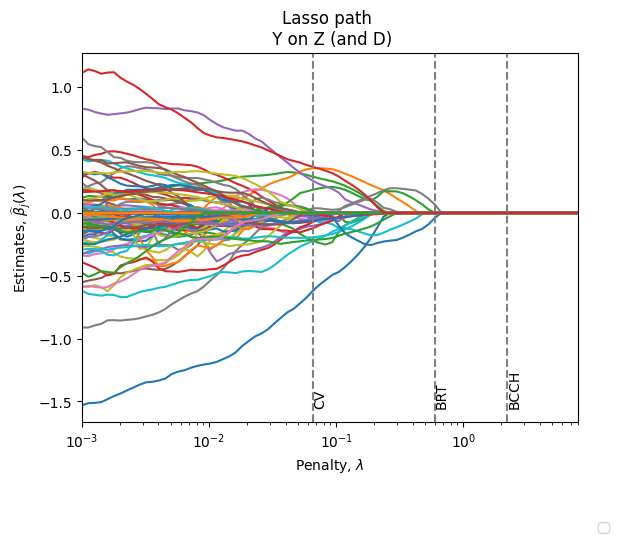

Selected vars 2. stage, CV penalty: ['lgdp_initial' 'investment_rate' 'pop_growth^2' 'pop_growth temp'
 'pop_growth malfal' 'investment_rate cenlong' 'investment_rate pmuslim'
 'tropicar oilres' 'distr^2' 'distr temp' 'distr goldm' 'distr pcatholic'
 'distc area' 'elevavg area_ar' 'elevavg rough' 'elevstd area'
 'kgatr malfal' 'precip malfal' 'abslat malfal' 'abslat pcatholic'
 'cenlong^2' 'iron pprotest' 'zinc pmuslim' 'malfal pprotest'
 'pprotest pcatholic' 'demBMR']
Selected vars 2. stage, BRT penalty: ['malfal^2' 'asia']
Selected vars 2. stage, BCCH penalty: []
Double Lasso estimates:
  CV: -1.279076344887
  BRT: -0.296878880987
  BCCH: -0.120927076306


In [ ]:
# Prepare first stage Lasso paths
coefs = []

for penal in penalty_grid:
    fit = Lasso(alpha=penal,  max_iter=max_iterations).fit(Z_std, D)
    coefs.append(fit.coef_)

plot_lasso_path(penalty_grid=penalty_grid, coefs=coefs, title="Lasso path, first stage \n D on Z", 
                vlines={'BCCH':BCCH(Z_std, D),'BRT':BRT(Z_std, D), 'CV':penalty_CV}) # legends=zs,

# Step 1: Lasso D on Z
PDL_fit_D_on_Z_CV = LassoCV(alphas=penalty_grid, cv=5, max_iter=max_iterations).fit(Z_std, D.reshape(-1,))
PDL_fit_D_on_Z_BRT = Lasso(alpha=BRT(Z_std, D), max_iter=max_iterations).fit(Z_std, D.reshape(-1,))
PDL_fit_D_on_Z_BCCH = Lasso(alpha=BCCH(Z_std, D), max_iter=max_iterations).fit(Z_std, D.reshape(-1,))

# Get selected variables
PDL_coefs_D_on_Z_CV = PDL_fit_D_on_Z_CV.coef_
PDL_selected_vars_Z_CV = (PDL_coefs_D_on_Z_CV != 0)
PDL_coefs_D_on_Z_BRT = PDL_fit_D_on_Z_BRT.coef_
PDL_selected_vars_Z_BRT = (PDL_coefs_D_on_Z_BRT != 0)
PDL_coefs_D_on_Z_BCCH = PDL_fit_D_on_Z_BCCH.coef_
PDL_selected_vars_Z_BCCH = (PDL_coefs_D_on_Z_BCCH != 0)
print("Selected vars 1. stage, CV penalty:", np.array(names_zs)[PDL_selected_vars_Z_CV])
print("Selected vars 1. stage, BRT penalty:", np.array(names_zs)[PDL_selected_vars_Z_BRT])
print("Selected vars 1. stage, BCCH penalty:", np.array(names_zs)[PDL_selected_vars_Z_BCCH])

# Residuals for step 1.
PDL_res_D_Z_CV = D - PDL_fit_D_on_Z_CV.predict(Z_std)
PDL_res_D_Z_BRT = D - PDL_fit_D_on_Z_BRT.predict(Z_std)
PDL_res_D_Z_BCCH = D - PDL_fit_D_on_Z_BCCH.predict(Z_std)
print("D.shape:", D.shape)
print("fit_D_on_Z_BRT.predict(Z_std).shape:", PDL_fit_D_on_Z_BRT.predict(Z_std).shape)
print("res_D_Z_BRT.shape: ",PDL_res_D_Z_BRT.shape)
# Lasso path for Y on Z (and D)

coefs = []
for penal in penalty_grid:
    fit = Lasso(alpha=penal,  max_iter=max_iterations).fit(X_std, y)
    coefs.append(fit.coef_)
plot_lasso_path(penalty_grid=penalty_grid, coefs=coefs, title="Lasso path \n Y on Z (and D)",
                vlines={'BCCH':BCCH(X_std, y),'BRT':BRT(X_std, y), 'CV':penalty_CV}) #  legends=zs,


# Step 2: Lasso Y on Z and D)
PDL_fit_Y_on_Z_D_CV = LassoCV(alphas=penalty_grid, cv=5, max_iter=max_iterations).fit(X_std, y.reshape(-1,))
PDL_fit_Y_on_Z_D_BRT = Lasso(alpha=BRT(X_tilde=X_std, y=y), max_iter=max_iterations).fit(X_std, y.reshape(-1,))
PDL_fit_Y_on_Z_D_BCCH = Lasso(alpha=BCCH(X_tilde=X_std, y=y), max_iter=max_iterations).fit(X_std, y.reshape(-1,))

# Get selected variables
PDL_coefs_Y_on_Z_D_CV = PDL_fit_Y_on_Z_D_CV.coef_
PDL_selected_vars_Y_Z_D_CV = (PDL_coefs_Y_on_Z_D_CV != 0)
# Z_J_CV = Z[:, coefs_Y_on_Z_D_CV != 0]
PDL_coefs_Y_on_Z_D_BRT = PDL_fit_Y_on_Z_D_BRT.coef_
PDL_selected_vars_Y_Z_D_BRT = (PDL_coefs_Y_on_Z_D_BRT != 0)
PDL_coefs_Y_on_Z_D_BCCH = PDL_fit_Y_on_Z_D_BCCH.coef_
PDL_selected_vars_Y_Z_D_BCCH = (PDL_coefs_Y_on_Z_D_BCCH != 0)
print("Selected vars 2. stage, CV penalty:", np.array(names_xs)[PDL_selected_vars_Y_Z_D_CV])
print("Selected vars 2. stage, BRT penalty:", np.array(names_xs)[PDL_selected_vars_Y_Z_D_BRT])
print("Selected vars 2. stage, BCCH penalty:", np.array(names_xs)[PDL_selected_vars_Y_Z_D_BCCH])

# Residuals for step 2.
PDL_res_Y_X_CV = y - PDL_fit_Y_on_Z_D_CV.predict(X_std).reshape(-1,)
PDL_res_Y_Z_D_CV = PDL_res_Y_X_CV + D_std*PDL_coefs_Y_on_Z_D_CV[0]

PDL_res_Y_X_BRT = y - PDL_fit_Y_on_Z_D_BRT.predict(X_std).reshape(-1,)
PDL_res_Y_Z_D_BRT = PDL_res_Y_X_BRT + D_std*PDL_coefs_Y_on_Z_D_BRT[0]

PDL_res_Y_X_BCCH = y - PDL_fit_Y_on_Z_D_BCCH.predict(X_std).reshape(-1,)
PDL_res_Y_Z_D_BCCH = PDL_res_Y_X_BCCH + D_std*PDL_coefs_Y_on_Z_D_BCCH[0]


def alpha_check(res_D, res_Y):
    num = res_D.T @ res_Y
    den = res_D.T @ res_D
    alpha = num / den
    return alpha

alpha_PDL_CV = alpha_check(PDL_res_D_Z_CV, PDL_res_Y_Z_D_CV) 
alpha_PDL_BRT = alpha_check(PDL_res_D_Z_BRT, PDL_res_Y_Z_D_BRT)
alpha_PDL_BCCH = alpha_check(PDL_res_D_Z_BCCH, PDL_res_Y_Z_D_BCCH)

print("Double Lasso estimates:")
print("  CV:", alpha_PDL_CV.round(rounding_digits))
print("  BRT:", alpha_PDL_BRT.round(rounding_digits))
print("  BCCH:", alpha_PDL_BCCH.round(rounding_digits))

In [55]:
# PDL_selected_vars_Z_BRT = (PDL_coefs_D_on_Z_BRT != 0)
# PDL_selected_vars_Z_BCCH = (PDL_coefs_D_on_Z_BCCH != 0)
# PDL_selected_vars_Y_Z_D_BRT = (PDL_coefs_Y_on_Z_D_BRT != 0)
# PDL_selected_vars_Y_Z_D_BCCH = (PDL_coefs_Y_on_Z_D_BCCH != 0)

# PDL_union_BCCH = np.union1d(np.array(names_zs)[PDL_selected_vars_Z_BCCH], np.array(names_xs)[PDL_selected_vars_Y_Z_D_BCCH])
# Z_1_BCCH = Z_final[:, PDL_selected_vars_Z_BCCH]
# print(Z_1_BCCH.shape)
# Z_2_BCCH = X[:, PDL_selected_vars_Y_Z_D_BCCH]
# print(Z_2_BCCH.shape)
# xx = np.column_stack((D ,Z_1_BCCH, Z_2_BCCH, np.ones(X.shape[0])))
# def variance(res_X, res_Y):
#     n = res_X.shape[0]
#     num = res_X**2 @ res_Y**2 / n
#     denom = (res_X.T @ res_X / n)**2
#     sigma2_PDL = num / denom
    
#     return sigma2_PDL

# def CI_se_low_high(alpha_estimate, variance):
#     se = np.sqrt(variance)
#     q = norm.ppf(1-0.025)
#     CI_low = alpha_estimate - q * se
#     CI_high = alpha_estimate + q * se
    
#     return se, CI_low, CI_high


# yy = y
# N = xx.shape[0]
# # Calculate OLS estimate
# coefs_PSL = np.linalg.inv(xx.T@xx)@xx.T@yy
# print(np.linalg.inv(xx.T@xx).shape)
# alpha_OLS = coefs_PSL[0]
# res_OLS = yy - xx @ coefs_PSL
# # Estimate variance
# SSR = res_OLS.T@res_OLS
# sigma2_OLS = SSR/(N-xx.shape[1])
# var = sigma2_OLS*np.linalg.inv(xx.T@xx)

# # Calculate standard errors
# se = np.sqrt(np.diagonal(var)).reshape(-1,1)

# # Get standard error of alpha
# se_OLS = se[1][0] / N 

# # Display standard error
# print("se_OLS = ",se_OLS.round(2))
# # Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
# q = norm.ppf(0.95) # Fill in

# # Calculate confidence interval
# CI_low_OLS  = alpha_OLS-q*se_OLS
# CI_high_OLS = alpha_OLS+q*se_OLS

# # Display confidence interval
# CI_OLS =  (((alpha_OLS-q*se_OLS).round(10),(alpha_OLS+q*se_OLS).round(10)))
# print(alpha_OLS.round(10))
# print("CI_OLS = ",(CI_low_OLS.round(10),CI_high_OLS.round(10)))
# # BRT
# # Y = lgdp_initial + malfak^2 + asia + uvdamage + constant
# # x_brt = 
# # BCCH
# # Y = lgdp_initial +  constant

# # alpha_PDL_BCCH =  -0.120927076306   BCCH: se = 1.130464150753 , CI = [ -2.336596097596 , 2.094741944983 ]


In [56]:
# PPOL, Post Partialling Out Lasso

# Step 1 Lasso D on Z
PPOL_fit_CV_D_Z = LassoCV(alphas=penalty_grid,  cv=5, max_iter=max_iterations).fit(Z_std, D.reshape(-1,))
PPOL_coefs_Z_D_CV = PPOL_fit_CV_D_Z.coef_
PPOL_res_D_Z_CV = D.reshape(-1,) - PPOL_fit_CV_D_Z.predict(Z_std)


PPOL_penalty_BRT_D_Z = BRT(Z_std, D.reshape(-1,))
PPOL_fit_BRT_D_Z = Lasso(alpha=PPOL_penalty_BRT_D_Z, max_iter=max_iterations).fit(Z_std, D.reshape(-1,))
PPOL_coefs_BRT_Z_D = PPOL_fit_BRT_D_Z.coef_
PPOL_res_BRT_D_Z = D.reshape(-1,) - PPOL_fit_BRT_D_Z.predict(Z_std)

PPOL_penalty_BCCH_D_Z = BCCH(Z_std, D.reshape(-1,))
PPOL_fit_BCCH_D_Z = Lasso(alpha=PPOL_penalty_BCCH_D_Z, max_iter=max_iterations).fit(Z_std, D.reshape(-1,))
PPOL_coefs_BCCH_Z_D = PPOL_fit_BCCH_D_Z.coef_
PPOL_res_BCCH_D_Z = D.reshape(-1,) - PPOL_fit_BCCH_D_Z.predict(Z_std)


# Get selected variables
PPOL_coefs_D_on_Z_CV = PPOL_coefs_Z_D_CV
PPOL_selected_vars_Z_CV = (PPOL_coefs_D_on_Z_CV != 0)
PPOL_coefs_D_on_Z_BRT = PPOL_coefs_BRT_Z_D
PPOL_selected_vars_Z_BRT = (PPOL_coefs_D_on_Z_BRT != 0)
PPOL_coefs_D_on_Z_BCCH = PPOL_coefs_BCCH_Z_D
PPOL_selected_vars_Z_BCCH = (PPOL_coefs_D_on_Z_BCCH != 0)
print("Selected vars 1. stage, CV penalty:", np.array(names_zs)[PPOL_selected_vars_Z_CV])
print("Selected vars 1. stage, BRT penalty:", np.array(names_zs)[PPOL_selected_vars_Z_BRT])
print("Selected vars 1. stage, BCCH penalty:", np.array(names_zs)[PPOL_selected_vars_Z_BCCH])

# Step 2 Lasso Y on Z
PPOL_fit_CV_Y_Z = LassoCV(alphas=penalty_grid,  cv=5, max_iter=max_iterations).fit(Z_std, y.reshape(-1,))
PPOL_coefs_Z_Y_CV = PPOL_fit_CV_Y_Z.coef_
PPOL_res_Y_Z_D_CV = y.reshape(-1,) - PPOL_fit_CV_Y_Z.predict(Z_std)

PPOL_penalty_BRT_Y_Z = BRT(Z_std, y.reshape(-1,))
PPOL_fit_BRT_Y_Z = Lasso(alpha=PPOL_penalty_BRT_Y_Z, max_iter=max_iterations).fit(Z_std, y.reshape(-1,))
PPOL_coefs_BRT_Z_Y = PPOL_fit_BRT_Y_Z.coef_
PPOL_res_BRT_Y_Z = y.reshape(-1,) - PPOL_fit_BRT_Y_Z.predict(Z_std)

PPOL_penalty_BCCH_Y_Z = BCCH(Z_std, y.reshape(-1,))
PPOL_fit_BCCH_Y_Z = Lasso(alpha=PPOL_penalty_BCCH_Y_Z, max_iter=max_iterations).fit(Z_std, y.reshape(-1,))
PPOL_coefs_BCCH_Z_Y = PPOL_fit_BCCH_Y_Z.coef_
PPOL_res_Y_Z_D_BCCH = y.reshape(-1,) - PPOL_fit_BCCH_Y_Z.predict(Z_std)

PPOL_coefs_Z_Y_CV = PPOL_coefs_Z_Y_CV
PPOL_selected_vars_Z_CV = (PPOL_coefs_Z_Y_CV != 0)
PPOL_coefs_BRT_Z_Y = PPOL_coefs_BRT_Z_Y
PPOL_selected_vars_Z_BRT = (PPOL_coefs_BRT_Z_Y != 0)
PPOL_coefs_BCCH_Z_Y = PPOL_coefs_BCCH_Z_Y
PPOL_selected_vars_Z_BCCH = (PPOL_coefs_BCCH_Z_Y != 0)
print("Selected vars 2. stage, CV penalty:", np.array(names_zs)[PPOL_selected_vars_Z_CV])
print("Selected vars 2. stage, BRT penalty:", np.array(names_zs)[PPOL_selected_vars_Z_BRT])
print("Selected vars 2. stage, BCCH penalty:", np.array(names_zs)[PPOL_selected_vars_Z_BCCH])


# Step 3 Estimate alpha

alpha_PPOL_CV = alpha_check(PPOL_res_D_Z_CV, PPOL_res_Y_Z_D_CV)
alpha_PPOL_BRT = alpha_check(PPOL_res_BRT_D_Z, PPOL_res_BRT_Y_Z)
alpha_PPOL_BCCH = alpha_check(PPOL_res_BCCH_D_Z, PPOL_res_Y_Z_D_BCCH)

print("PPOL estimates:")
print("CV:", alpha_PPOL_CV.round(rounding_digits))
print("BRT:", alpha_PPOL_BRT.round(rounding_digits))
print("BCCH:", alpha_PPOL_BCCH.round(rounding_digits))


Selected vars 1. stage, CV penalty: ['uvdamage' 'pop_growth suitavg' 'pop_growth abslat' 'investment_rate^2'
 'investment_rate pprotest' 'investment_rate pcatholic' 'distr goldm'
 'distr silv' 'distc suitavg' 'distc precip' 'distc cenlong'
 'suitavg abslat' 'elevavg^2' 'elevavg precip' 'elevavg cenlong'
 'elevstd area_ar' 'elevstd malfal' 'kgatr abslat' 'area pmuslim'
 'abslat^2' 'abslat rough' 'abslat pcatholic' 'cenlong area_ar'
 'area_ar pcatholic' 'oilres malfal' 'iron pprotest' 'iron pcatholic'
 'iron pmuslim' 'zinc pmuslim' 'pcatholic pmuslim' 'landlock' 'africa'
 'asia' 'yellow' 'dem' 'demCGV']
Selected vars 1. stage, BRT penalty: ['uvdamage']
Selected vars 1. stage, BCCH penalty: []
Selected vars 2. stage, CV penalty: ['investment_rate' 'pop_growth malfal' 'investment_rate cenlong'
 'tropicar oilres' 'distr^2' 'distr suitgini' 'distr goldm'
 'distr pcatholic' 'distcr cenlong' 'elevstd area_ar' 'area oilres'
 'area pmuslim' 'abslat malfal' 'cenlong^2' 'cenlong area_ar'
 'iron pp

#### Confidence intervals

In [ ]:
def variance(res_X, res_Y):
    n = res_X.shape[0]
    num = res_X**2 @ res_Y**2 / n
    denom = (res_X.T @ res_X / n)**2
    sigma2_PDL = num / denom
    
    return sigma2_PDL

def CI_se_low_high(alpha_estimate, variance):
    n = X_std.shape[0]
    se = np.sqrt(variance/n)
    q = norm.ppf(1-0.025)
    CI_low = alpha_estimate - q * se
    CI_high = alpha_estimate + q * se
    
    return se, CI_low, CI_high




In [58]:
# CI OLS with and without controls
# Variance without controls
variance_OLS_no_controls = variance(res_OLS_no_controls, res_OLS_no_controls)
se_OLS_no_controls, CI_low_OLS_no_controls, CI_high_OLS_no_controls = CI_se_low_high(beta_hat_no_controls[0], variance_OLS_no_controls)
print("OLS without controls:")
print("Alpha estimate (treatment effect of lgdp_initial):", round(beta_hat_no_controls[0], rounding_digits), "se =", round(se_OLS_no_controls, rounding_digits),
      "CI = [", round(CI_low_OLS_no_controls, rounding_digits), ",", round(CI_high_OLS_no_controls, rounding_digits), "]")
# Variance with controls
variance_OLS_w_controls = variance(res_OLS_w_controls, res_OLS_w_controls)
se_OLS_w_controls, CI_low_OLS_w_controls, CI_high_OLS_w_controls = CI_se_low_high(beta_hat_w_controls[0], variance_OLS_w_controls)
print("OLS with all controls (no polynomials):")
print("Alpha estimate (treatment effect of lgdp_initial):", round(beta_hat_w_controls[0], rounding_digits), "se =", round(se_OLS_w_controls, rounding_digits),
      "CI = [", round(CI_low_OLS_w_controls, rounding_digits), ",", round(CI_high_OLS_w_controls, rounding_digits), "]")

OLS without controls:
Alpha estimate (treatment effect of lgdp_initial): -0.166172775192 se = 0.24361706463 CI = [ -0.643653447886 , 0.311307897501 ]
OLS with all controls (no polynomials):
Alpha estimate (treatment effect of lgdp_initial): -1.926694888468 se = 0.193798830877 CI = [ -2.306533617233 , -1.546856159703 ]


In [ ]:
# CI PSL


In [59]:
# CI for PDL
variance_CV_PDL = variance(PDL_res_D_Z_CV, PDL_res_Y_Z_D_CV)
variance_BRT_PDL = variance(PDL_res_D_Z_BRT, PDL_res_Y_Z_D_BRT)
variance_BCCH_PDL = variance(PDL_res_D_Z_BCCH, PDL_res_Y_Z_D_BCCH)

se_CV_PDL, CI_low_CV_PDL, CI_high_CV_PDL = CI_se_low_high(alpha_PDL_CV, variance_CV_PDL)
se_BRT_PDL, CI_low_BRT_PDL, CI_high_BRT_PDL = CI_se_low_high(alpha_PDL_BRT, variance_BRT_PDL)
se_BCCH_PDL, CI_low_BCCH_PDL, CI_high_BCCH_PDL = CI_se_low_high(alpha_PDL_BCCH, variance_BCCH_PDL)

print("PDL Confidence Intervals:")
print("alpha_PDL_CV = " , alpha_PDL_CV.round(rounding_digits), "  CV: se =", se_CV_PDL.round(rounding_digits), ", CI = [", CI_low_CV_PDL.round(rounding_digits), ",", CI_high_CV_PDL.round(rounding_digits), "]")
print("alpha_PDL_BRT = " , alpha_PDL_BRT.round(rounding_digits), "  BRT: se =", se_BRT_PDL.round(rounding_digits), ", CI = [", CI_low_BRT_PDL.round(rounding_digits), ",", CI_high_BRT_PDL.round(rounding_digits), "]")
print("alpha_PDL_BCCH = " , alpha_PDL_BCCH.round(rounding_digits), "  BCCH: se =", se_BCCH_PDL.round(rounding_digits), ", CI = [", CI_low_BCCH_PDL.round(rounding_digits), ",", CI_high_BCCH_PDL.round(rounding_digits), "]")


PDL Confidence Intervals:
alpha_PDL_CV =  -1.279076344887   CV: se = 0.298956532565 , CI = [ -1.865020381657 , -0.693132308117 ]
alpha_PDL_BRT =  -0.296878880987   BRT: se = 0.17654860658 , CI = [ -0.642907791404 , 0.04915002943 ]
alpha_PDL_BCCH =  -0.120927076306   BCCH: se = 0.120507883377 , CI = [ -0.357118187579 , 0.115264034966 ]


In [60]:
# CI for PPOL
variance_CV_PPOL = variance(PPOL_res_D_Z_CV, PPOL_res_Y_Z_D_CV)
variance_BRT_PPOL = variance(PPOL_res_BRT_D_Z, PPOL_res_BRT_Y_Z)
variance_BCCH_PPOL = variance(PPOL_res_BCCH_D_Z, PPOL_res_Y_Z_D_BCCH)

se_CV_PPOL, CI_low_CV_PPOL, CI_high_CV_PPOL = CI_se_low_high(alpha_PPOL_CV, variance_CV_PPOL)
se_BRT_PPOL, CI_low_BRT_PPOL, CI_high_BRT_PPOL = CI_se_low_high(alpha_PPOL_BRT, variance_BRT_PPOL)
se_BCCH_PPOL, CI_low_BCCH_PPOL, CI_high_BCCH_PPOL = CI_se_low_high(alpha_PPOL_BCCH, variance_BCCH_PPOL)
print("PPOL Confidence Intervals:")
print("alpha_PPOL_CV = " , alpha_PPOL_CV.round(rounding_digits), "  CV: se =", se_CV_PPOL.round(rounding_digits), ", CI = [", CI_low_CV_PPOL.round(rounding_digits), ",", CI_high_CV_PPOL.round(rounding_digits), "]")
print("alpha_PPOL_BRT = " , alpha_PPOL_BRT.round(rounding_digits), "  BRT: se =", se_BRT_PPOL.round(rounding_digits), ", CI = [", CI_low_BRT_PPOL.round(rounding_digits), ",", CI_high_BRT_PPOL.round(rounding_digits), "]")
print("alpha_PPOL_BCCH = " , alpha_PPOL_BCCH.round(rounding_digits), "  BCCH: se =", se_BCCH_PPOL.round(rounding_digits), ", CI = [", CI_low_BCCH_PPOL.round(rounding_digits), ",", CI_high_BCCH_PPOL.round(rounding_digits), "]")


PPOL Confidence Intervals:
alpha_PPOL_CV =  -1.04348339907   CV: se = 0.264243430224 , CI = [ -1.56139100546 , -0.52557579268 ]
alpha_PPOL_BRT =  -0.296887125532   BRT: se = 0.176543135456 , CI = [ -0.642905312744 , 0.04913106168 ]
alpha_PPOL_BCCH =  -0.120927076306   BCCH: se = 0.120507883377 , CI = [ -0.357118187579 , 0.115264034966 ]
